In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 데이터 로드
df = pd.read_csv('/content/drive/MyDrive/통계데이터사이언스/lending_club/preprocessed_data_ver.2.3._IRR+LOG+BINARY.csv')

In [4]:
# 모든 열 다 보기
pd.set_option('display.max_columns', None)

# 모든 행 다 보기
pd.set_option('display.max_rows', None)

# 열 너비 넉넉하게
pd.set_option('display.width', None)

# 열 안의 값 자르지 않게
pd.set_option('display.max_colwidth', None)

In [5]:
df.head()

,funded_amnt,term,installment,emp_length,annual_inc,issue_d,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,recoveries,collection_recovery_fee,last_pymnt_d,last_fico_range_high,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,default,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,addr_state_nan,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,home_ownership_nan,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,purpose_nan,emp_length_missing,percent_bc_gt_75_missing,delinq_amnt_missing,annual_inc_missing,open_act_il_missing,mths_since_recent_inq_missing,collection_recovery_fee_missing,mths_since_rcnt_il_missing,revol_bal_missing,open_il_12m_missing,all_util_missing,fico_range_low_missing,open_acc_6m_missing,delinq_2yrs_missing,open_acc_missing,total_acc_missing,inq_last_12m_missing,funded_amnt_missing,installment_missing,open_il_24m_missing,open_rv_24m_missing,inq_last_6mths_missing,open_rv_12m_missing,acc_now_delinq_missing,last_fico_range_high_missing,pub_rec_missing,total_bal_il_missing,recoveries_missing,max_bal_bc_missing,il_util_missing,mths_since_last_delinq_missing,fico_range_high_missing,mths_since_recent_revol_delinq_missing
0,6000.0,36,187.94,2.0,10.714440,2017-12-01,2.269028,1,755.0,759.0,0.0,22.0,14.0,0,8.036250,14.0,36.0,0.00,0.000,Apr-2020,764.0,0,0,0,50054.0,1.0,10.0,3.0,3.0,3.0,46964.0,83.0,1.0,1.0,8.036250,64.0,10.003378,2.0,4.0,8.256088,9.385218,20.6,0,0.0,147.0,135.0,12.0,3.0,1.0,56.0,3.0,0.0,0.0,1.0,1.0,4.0,28.0,4.0,7.0,1.0,14.0,0,0,0,4.0,97.1,0.0,0,0,11.272280,10.820878,9.615872,10.942208,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,23200.0,60,680.82,10.0,11.608245,2016-07-01,3.575151,1,670.0,674.0,1.0,10.0,24.0,0,9.735660,55.9,60.0,5260.00,946.800,Dec-2016,639.0,0,0,0,606327.0,1.0,10.0,1.0,2.0,10.0,277552.0,90.0,4.0,6.0,8.455105,85.0,10.317450,7.0,8.0,10.137175,8.702012,70.4,0,0.0,126.0,277.0,6.0,6.0,2.0,7.0,0.0,10.0,0.0,10.0,8.0,14.0,36.0,12.0,22.0,10.0,24.0,0,0,0,5.0,94.8,37.5,0,0,13.386134,12.592905,9.918425,12.582679,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [6]:
# 독립변수에서 제외할 변수 목록
drop_cols = [
    'term', 'last_pymnt_d', 'installment', 'funded_amnt',
    'recoveries', 'collection_recovery_fee', 'default', 'issue_d'
]

X = df.drop(columns=drop_cols)
y = df['default']

In [7]:
!pip install fredapi

In [8]:
from fredapi import Fred

# FRED API 연결
fred = Fred(api_key="05ceea53cbc890aa3e4416729c89001b")  # 실제 API 키로 대체해야 함

# 미국 3년 만기 국채 수익률(GS3) 시계열 불러오기
series = fred.get_series('GS3')  # pandas.Series 형식으로 반환됨


print(series.head())

1953-04-01    2.51
1953-05-01    2.72
1953-06-01    2.74
1953-07-01    2.62
1953-08-01    2.58
dtype: float64


In [9]:
def get_nearest_rate(issue_date, rate_series):
    if pd.isnull(issue_date):
        return np.nan
    try:
        idx = rate_series.index.get_indexer([issue_date], method='nearest')[0]
        return rate_series.iloc[idx] / 100  # % 단위 → 소수로 변환
    except Exception as e:
        print(f"Error: {issue_date} ▶ {e}")
        return np.nan


df['risk_free_rate'] = df['issue_d'].apply(lambda x: get_nearest_rate(x, series))


In [10]:
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'])
df['issue_d'] = pd.to_datetime(df['issue_d'])  # 혹시 모르니 이것도

/tmp/ipython-input-4242469769.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'])


In [11]:
print(df[['issue_d', 'risk_free_rate', 'last_pymnt_d']].head())

     issue_d  risk_free_rate last_pymnt_d
0 2017-12-01          0.0196   2020-04-01
1 2016-07-01          0.0079   2016-12-01
2 2017-10-01          0.0168   2019-08-01
3 2017-05-01          0.0148   2019-03-01
4 2015-09-01          0.0101   2018-10-01


In [12]:
from dateutil.relativedelta import relativedelta

def create_cash_flow_from_dates(row):
    try:
        term = int(row['term'])
        default = int(row['default'])
        issue_d = row['issue_d']  # 이미 datetime 형식
        last_pymnt_d = pd.to_datetime(row['last_pymnt_d'])  # 이건 문자열일 수도 있으니 변환
        installment = float(row['installment'])
        funded_amnt = float(row['funded_amnt'])
        recoveries = float(row['recoveries'])
        collection_fee = float(row['collection_recovery_fee'])

        # 첫 현금흐름: 대출 실행
        cash_flow = [-funded_amnt]

        if pd.isnull(issue_d) or pd.isnull(last_pymnt_d):
            return np.nan

        # 몇 회차까지 납입했는지 계산
        delta = relativedelta(last_pymnt_d, issue_d)
        last_pymnt_num = delta.years * 12 + delta.months

        for month in range(1, term + 1):
            if default == 1:
                if month <= last_pymnt_num:
                    cash_flow.append(installment)
                elif month == last_pymnt_num + 1:
                    cash_flow.append(recoveries - collection_fee)
                else:
                    cash_flow.append(0)
            else:
                cash_flow.append(installment)

        return cash_flow

    except Exception as e:
        print(f"[오류] index={row.name}, error={e}")
        return np.nan


In [13]:
df['cash_flow'] = df.apply(create_cash_flow_from_dates, axis=1)

In [14]:
!pip install numpy-financial

In [15]:
import numpy_financial as npf

def get_irr(cash_flow):
    if not isinstance(cash_flow, list) or len(cash_flow) == 0:
        return np.nan
    irr_monthly = npf.irr(cash_flow)
    if irr_monthly is None or np.isnan(irr_monthly):
        return np.nan
    return (1 + irr_monthly) ** 12 - 1  # 연환산

In [16]:
df['irr'] = df['cash_flow'].apply(get_irr)

In [17]:
df['irr'] = df['irr'].fillna(df['risk_free_rate'])

In [19]:
# 결과 저장용 리스트
best_models = []
best_thresholds = []
validation_sharpes = []
test_sharpes = []
test_approval_rates = []
test_irr_means = []
test_irr_positive_rates = []


# Sharpe 계산 함수
def calculate_sharpe(returns, risk_free_rates):
    excess = returns - risk_free_rates
    if excess.std(ddof=1) == 0:
        return -np.inf
    return excess.mean() / excess.std(ddof=1)

In [24]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import joblib
import json
import os

# 저장 경로 설정
SAVE_DIR = "/content/drive/MyDrive/통계데이터사이언스/lending_club"
os.makedirs(SAVE_DIR, exist_ok=True)

# LightGBM 하이퍼파라미터 공간 정의
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'num_leaves': [15, 31, 63],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 전체 데이터를 그대로 사용
# X, y는 이미 정의되어 있다고 가정

model_base = lgb.LGBMClassifier(random_state=42)

search = RandomizedSearchCV(
    model_base,
    param_distributions=param_dist,
    n_iter=5,        # 필요에 따라 늘려도 됩니다
    scoring='roc_auc',
    cv=2,
    verbose=2,
    n_jobs=-1
)

search.fit(X, y)

# 최적 하이퍼파라미터 저장
best_params = search.best_params_
print("✅ Best hyperparameters (from tuning):", best_params)


Fitting 2 folds for each of 5 candidates, totalling 10 fits
✅ Best hyperparameters (from tuning): {'subsample': 1.0, 'num_leaves': 63, 'n_estimators': 200, 'min_child_samples': 10, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


In [22]:
best_params = {
    'subsample': 1.0,
    'num_leaves': 63,
    'n_estimators': 200,
    'min_child_samples': 10,
    'max_depth': 10,
    'learning_rate': 0.05,
    'colsample_bytree': 1.0
}


In [23]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import joblib
import json

# 결과 저장용 리스트
best_models = []
best_thresholds = []
validation_sharpes = []
test_sharpes = []
test_approval_rates = []
test_irr_means = []
test_irr_positive_rates = []

# 베스트 모델 저장 변수
best_model = None
best_sharpe_overall = -np.inf
best_model_index = None
best_threshold_overall = None
best_params_overall = None

for i in tqdm(range(100)):
    # 데이터 분할
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, random_state=i, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=i, stratify=y_temp
    )

    # LightGBM 모델 학습
    model = lgb.LGBMClassifier(**best_params, random_state=i, n_jobs=-1)
    model.fit(X_train, y_train)

    # 검증셋 예측 확률
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    thresholds = np.arange(0.0, 1.0, 0.05)

    best_sharpe = -np.inf
    best_threshold = None
    df_val = df.loc[X_val.index]

    for threshold in thresholds:
        approved_mask = y_pred_proba <= threshold
        denied_mask = ~approved_mask

        selected = df_val.copy()
        selected.loc[approved_mask, 'irr_adj'] = selected.loc[approved_mask, 'irr']
        selected.loc[denied_mask, 'irr_adj'] = selected.loc[denied_mask, 'risk_free_rate']

        returns = selected['irr_adj']
        risk_free = selected['risk_free_rate']
        valid = returns.notnull() & risk_free.notnull()

        if valid.sum() < 2:
            continue

        sharpe = calculate_sharpe(returns[valid], risk_free[valid])

        if sharpe > best_sharpe:
            best_sharpe = sharpe
            best_threshold = threshold

    best_models.append(model)
    best_thresholds.append(best_threshold)
    validation_sharpes.append(best_sharpe)

    # 테스트셋 평가
    y_test_proba = model.predict_proba(X_test)[:, 1]
    test_approved_mask = y_test_proba <= best_threshold
    df_test = df.loc[X_test.index]
    test_selected = df_test[test_approved_mask]

    returns_test = test_selected['irr']
    risk_free_test = test_selected['risk_free_rate']
    valid = returns_test.notnull() & risk_free_test.notnull()
    returns_test = returns_test[valid]
    risk_free_test = risk_free_test[valid]

    sharpe_test = calculate_sharpe(returns_test, risk_free_test)
    test_sharpes.append(sharpe_test)
    test_approval_rates.append(len(returns_test) / len(df_test))
    test_irr_means.append(returns_test.mean())
    test_irr_positive_rates.append((returns_test > 0).mean())

    # Best 모델 업데이트
    if sharpe_test > best_sharpe_overall:
        best_sharpe_overall = sharpe_test
        best_model = model
        best_model_index = i
        best_threshold_overall = best_threshold
        best_params_overall = model.get_params()

# Best 모델 저장
joblib.dump(best_model, f"{SAVE_DIR}/best_model_lgb.pkl")
with open(f"{SAVE_DIR}/best_model_threshold_lgb.json", "w") as f:
    json.dump({"threshold": best_threshold_overall}, f)
with open(f"{SAVE_DIR}/best_model_params_lgb.json", "w") as f:
    json.dump(best_params_overall, f)

# 최종 결과 출력
print("\n최종 결과 요약")
print("✅ Best model index:", best_model_index)
print("✅ Best validation Sharpe ratio:", validation_sharpes[best_model_index])
print("✅ Best test Sharpe ratio:", test_sharpes[best_model_index])
print("✅ Best approval rate:", test_approval_rates[best_model_index])
print("✅ Mean IRR:", test_irr_means[best_model_index])
print("✅ Positive IRR ratio:", test_irr_positive_rates[best_model_index])
print("✅ Best threshold:", best_thresholds[best_model_index])
print("✅ Best model params:", best_model.get_params())


  0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7558
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


  1%|          | 1/100 [00:30<50:38, 30.70s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7515
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


  2%|▏         | 2/100 [00:56<45:22, 27.78s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7522
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


  3%|▎         | 3/100 [01:22<43:21, 26.81s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7519
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


  4%|▍         | 4/100 [01:46<41:32, 25.97s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7512
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


  5%|▌         | 5/100 [02:11<40:41, 25.70s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7522
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


  6%|▌         | 6/100 [02:36<39:38, 25.30s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7510
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


  7%|▋         | 7/100 [03:03<40:03, 25.84s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7498
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


  8%|▊         | 8/100 [03:28<39:14, 25.60s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7540
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


  9%|▉         | 9/100 [03:54<39:07, 25.80s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7510
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 10%|█         | 10/100 [04:22<39:34, 26.38s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.249878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7532
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 11%|█         | 11/100 [04:48<39:09, 26.40s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.131885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7524
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 12%|█▏        | 12/100 [05:14<38:26, 26.21s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7503
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 13%|█▎        | 13/100 [05:41<38:18, 26.42s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7514
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 14%|█▍        | 14/100 [06:06<37:14, 25.99s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7515
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 15%|█▌        | 15/100 [06:31<36:09, 25.52s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7524
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 16%|█▌        | 16/100 [06:56<35:38, 25.46s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7523
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 17%|█▋        | 17/100 [07:20<34:45, 25.13s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7525
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 18%|█▊        | 18/100 [07:44<33:47, 24.72s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7545
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 19%|█▉        | 19/100 [08:09<33:25, 24.76s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.251606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7505
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 20%|██        | 20/100 [08:33<32:47, 24.60s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7535
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 21%|██        | 21/100 [08:56<31:55, 24.25s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7527
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 22%|██▏       | 22/100 [09:20<31:08, 23.96s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7534
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 23%|██▎       | 23/100 [09:45<31:16, 24.38s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7504
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 24%|██▍       | 24/100 [10:10<31:04, 24.53s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7529
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 25%|██▌       | 25/100 [10:34<30:27, 24.36s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7534
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 26%|██▌       | 26/100 [11:00<30:42, 24.90s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7521
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 27%|██▋       | 27/100 [11:25<30:22, 24.97s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7531
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 28%|██▊       | 28/100 [11:50<29:54, 24.93s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7511
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 29%|██▉       | 29/100 [12:14<29:17, 24.75s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7521
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 30%|███       | 30/100 [12:38<28:29, 24.42s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7521
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 31%|███       | 31/100 [13:02<28:01, 24.37s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7507
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 32%|███▏      | 32/100 [13:29<28:16, 24.95s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7537
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 33%|███▎      | 33/100 [13:52<27:25, 24.56s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7531
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 34%|███▍      | 34/100 [14:18<27:14, 24.77s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7535
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 35%|███▌      | 35/100 [14:41<26:20, 24.31s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7499
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 36%|███▌      | 36/100 [15:03<25:10, 23.61s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7498
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 37%|███▋      | 37/100 [15:27<25:03, 23.87s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.132390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7546
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 152
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 38%|███▊      | 38/100 [15:52<25:05, 24.28s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7540
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 39%|███▉      | 39/100 [16:15<24:16, 23.88s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7520
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 40%|████      | 40/100 [16:37<23:15, 23.25s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7549
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 41%|████      | 41/100 [17:01<22:58, 23.36s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7535
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 42%|████▏     | 42/100 [17:22<21:49, 22.57s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.412740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7541
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 43%|████▎     | 43/100 [17:43<21:11, 22.31s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7520
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 44%|████▍     | 44/100 [18:04<20:22, 21.83s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7543
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 45%|████▌     | 45/100 [18:24<19:33, 21.34s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.278257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7525
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 46%|████▌     | 46/100 [18:45<18:58, 21.08s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7500
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 47%|████▋     | 47/100 [19:05<18:26, 20.87s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7536
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 48%|████▊     | 48/100 [19:26<18:10, 20.98s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7537
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 49%|████▉     | 49/100 [19:52<19:06, 22.47s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.107559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7552
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 50%|█████     | 50/100 [20:19<19:52, 23.85s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7530
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 51%|█████     | 51/100 [20:45<19:58, 24.46s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7515
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 52%|█████▏    | 52/100 [21:09<19:31, 24.40s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7518
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 152
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 53%|█████▎    | 53/100 [21:36<19:39, 25.11s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7532
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 54%|█████▍    | 54/100 [21:58<18:30, 24.13s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.295097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7534
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 55%|█████▌    | 55/100 [22:18<17:13, 22.96s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7536
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 56%|█████▌    | 56/100 [22:39<16:21, 22.31s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7525
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 57%|█████▋    | 57/100 [22:59<15:33, 21.71s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7536
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 58%|█████▊    | 58/100 [23:20<14:52, 21.25s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7511
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 59%|█████▉    | 59/100 [23:41<14:32, 21.27s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7527
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 60%|██████    | 60/100 [24:04<14:34, 21.86s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7545
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 61%|██████    | 61/100 [24:28<14:39, 22.55s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7514
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 62%|██████▏   | 62/100 [24:50<14:02, 22.17s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7542
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 63%|██████▎   | 63/100 [25:11<13:33, 21.98s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.242908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7523
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 64%|██████▍   | 64/100 [25:35<13:33, 22.60s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7513
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 65%|██████▌   | 65/100 [25:55<12:46, 21.91s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7547
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 66%|██████▌   | 66/100 [26:16<12:08, 21.43s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7521
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 67%|██████▋   | 67/100 [26:37<11:42, 21.30s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7549
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 68%|██████▊   | 68/100 [26:58<11:21, 21.31s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7481
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 69%|██████▉   | 69/100 [27:20<11:03, 21.41s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.097212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7516
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 70%|███████   | 70/100 [27:40<10:36, 21.22s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7529
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 71%|███████   | 71/100 [28:01<10:12, 21.12s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7530
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 72%|███████▏  | 72/100 [28:23<09:54, 21.24s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7526
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 73%|███████▎  | 73/100 [28:43<09:27, 21.03s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7517
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 74%|███████▍  | 74/100 [29:08<09:31, 22.00s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7530
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 75%|███████▌  | 75/100 [29:37<10:06, 24.26s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.154372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7534
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 76%|███████▌  | 76/100 [30:05<10:05, 25.24s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7503
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 77%|███████▋  | 77/100 [30:30<09:37, 25.10s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.115151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7539
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 78%|███████▊  | 78/100 [30:52<08:53, 24.25s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7526
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 79%|███████▉  | 79/100 [31:20<08:55, 25.49s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7537
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 80%|████████  | 80/100 [31:48<08:42, 26.13s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7522
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 81%|████████  | 81/100 [32:16<08:28, 26.75s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7528
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 82%|████████▏ | 82/100 [32:44<08:09, 27.19s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7523
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 83%|████████▎ | 83/100 [33:12<07:43, 27.28s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.136487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7521
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 84%|████████▍ | 84/100 [33:40<07:21, 27.60s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7524
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 85%|████████▌ | 85/100 [34:08<06:53, 27.57s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7513
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 86%|████████▌ | 86/100 [34:36<06:27, 27.71s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.112832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7532
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 87%|████████▋ | 87/100 [35:04<06:03, 27.98s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7526
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 88%|████████▊ | 88/100 [35:34<05:41, 28.43s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7548
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 89%|████████▉ | 89/100 [36:00<05:06, 27.87s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7518
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 90%|█████████ | 90/100 [36:27<04:34, 27.45s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7531
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 91%|█████████ | 91/100 [36:54<04:07, 27.47s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7522
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 92%|█████████▏| 92/100 [37:21<03:38, 27.29s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7518
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 93%|█████████▎| 93/100 [37:49<03:12, 27.53s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7513
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 94%|█████████▍| 94/100 [38:15<02:42, 27.03s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7531
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 95%|█████████▌| 95/100 [38:40<02:12, 26.53s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7523
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 96%|█████████▌| 96/100 [39:06<01:44, 26.25s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7522
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 97%|█████████▋| 97/100 [39:33<01:19, 26.62s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.149236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7522
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 98%|█████████▊| 98/100 [40:00<00:53, 26.54s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.284889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7507
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


 99%|█████████▉| 99/100 [40:26<00:26, 26.40s/it]

[LightGBM] [Info] Number of positive: 130580, number of negative: 539113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.305828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7549
[LightGBM] [Info] Number of data points in the train set: 669693, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194985 -> initscore=-1.417939
[LightGBM] [Info] Start training from score -1.417939


100%|██████████| 100/100 [40:52<00:00, 24.52s/it]


최종 결과 요약
✅ Best model index: 11
✅ Best validation Sharpe ratio: 0.694343037856779
✅ Best test Sharpe ratio: 1.1298778609299924
✅ Best approval rate: 0.5972665209288991
✅ Mean IRR: 0.1213800395897723
✅ Positive IRR ratio: 0.9904821906711968
✅ Best threshold: 0.05
✅ Best model params: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': 10, 'min_child_samples': 10, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'num_leaves': 63, 'objective': None, 'random_state': 11, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [25]:
print("Best thresholds from 100 runs:")
print(best_thresholds)

print("\nValidation Sharpe Ratios from 100 runs:")
print(validation_sharpes)

print("\nTest Sharpe Ratios from 100 runs:")
print(test_sharpes)

print("\nTest Approval Rates:")
print(test_approval_rates)

print("\nTest IRR Means:")
print(test_irr_means)

print("\nTest IRR Positive Rates:")
print(test_irr_positive_rates)


Best thresholds from 100 runs:
[np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.05), np.float64(0.0

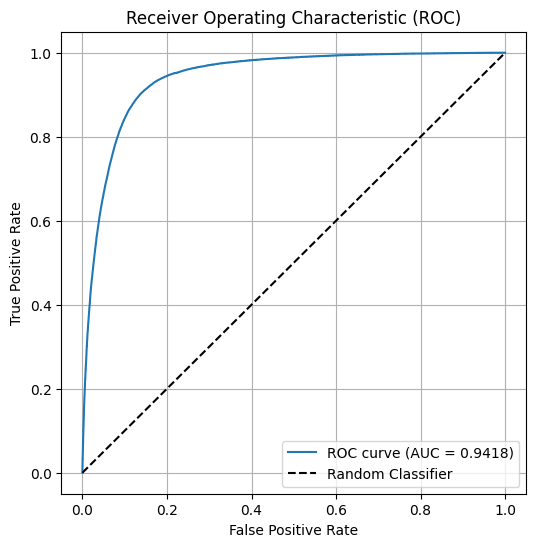

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 예: test set
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


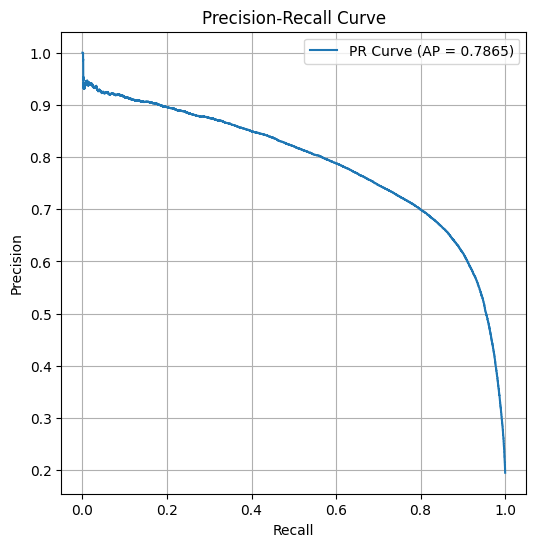

In [27]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
ap_score = average_precision_score(y_test, y_test_proba)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {ap_score:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()


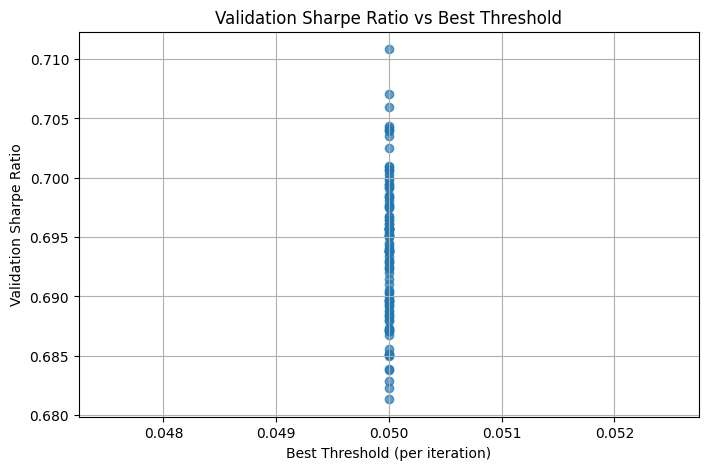

In [28]:
plt.figure(figsize=(8, 5))
plt.scatter(best_thresholds, validation_sharpes, alpha=0.7)
plt.title("Validation Sharpe Ratio vs Best Threshold")
plt.xlabel("Best Threshold (per iteration)")
plt.ylabel("Validation Sharpe Ratio")
plt.grid(True)
plt.show()


In [29]:
thresholds = np.arange(0.0, 1.0, 0.05)
sharpe_by_threshold = []

# df_val은 X_val의 인덱스를 기반으로 만듦
df_val = df.loc[X_val.index]
y_pred_proba = model.predict_proba(X_val)[:, 1]

for threshold in thresholds:
    approved_mask = y_pred_proba <= threshold
    denied_mask = ~approved_mask

    selected = df_val.copy()
    selected.loc[approved_mask, 'irr_adj'] = selected.loc[approved_mask, 'irr']
    selected.loc[denied_mask, 'irr_adj'] = selected.loc[denied_mask, 'risk_free_rate']

    returns = selected['irr_adj']
    risk_free = selected['risk_free_rate']
    valid = returns.notnull() & risk_free.notnull()

    if valid.sum() < 2:
        sharpe = np.nan
    else:
        sharpe = calculate_sharpe(returns[valid], risk_free[valid])

    sharpe_by_threshold.append(sharpe)


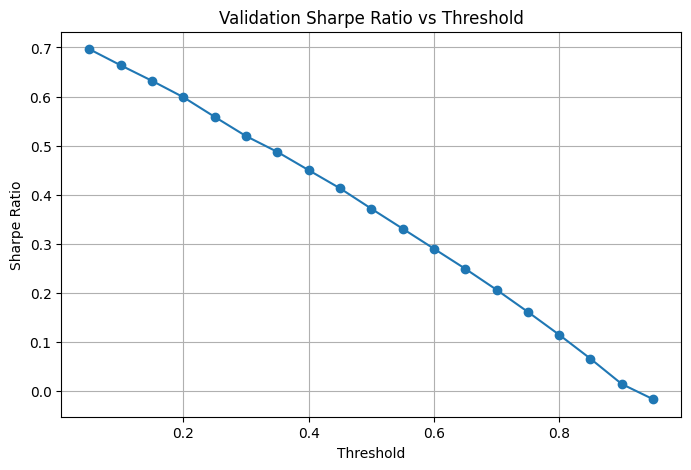

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(thresholds, sharpe_by_threshold, marker='o')
plt.title("Validation Sharpe Ratio vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.show()
